# Prostate cANcer graDe Assessment (PANDA) Challenge

This notebook will be used by the CIS 6115 students for Unit 5. 

Start by reading about the [Prostate cANcer graDe Assessment (PANDA) Challenge](https://www.kaggle.com/c/prostate-cancer-grade-assessment) in Kaggle. It is often good to read the top voted notebooks for the challenge also, which is Rohit Singh's [PANDA - EDA + Better Visualization+Simple Baseline](https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline). This notebook is actually based on [PANDA DenseNet Keras Starter GPU](https://www.kaggle.com/yeayates21/panda-densenet-keras-starter-gpu) by Matt Yates.

Image loading for this version was taken from Ibtesam Ahmed's [Simple Baseline- Keras VGG16](https://www.kaggle.com/ibtesama/simple-baseline-keras-vgg16)

## Chapter 10 & 11 

- Chapter 10: Introduction to Artificial Neural Networks with Keras - Part 2
- Chapter 11: Training Deep Neural Networks




## Writeup

Use the the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing) to answer the questions posed in this notebook****

## Walkthrough Video
​
Watch the [Unit 5 Walkthough Video by Tom](https://youtu.be/A5Oh95Yfw1E)



# Setting up Python tools

We'll use three libraries for this tutorial: 
- [pandas](http://pandas.pydata.org/) : dataframes for spreadsheet-like data analysis, reading CSV files, time series
- [numpy](http://www.numpy.org/) : for multidimensional data and linear algebra tools
- [matplotlib](http://matplotlib.org/) : Simple plotting and graphing
- [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) : more advanced graphing
- [scikit-learn](https://scikit-learn.org/stable/) : provides many machine learning algorithms and tools to training and test.
- [tensorflow](https://www.tensorflow.org/) : Google's backend library for neural networks and other machine learning
- [keras](https://keras.io/) : High level machine learning API that we run on top of Tensorflow




In [1]:
# First, we'll import pandas and numpy, two data processing libraries
import pandas as pd
import numpy as np

# We'll also import seaborn and matplot, twp Python graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import the needed sklearn libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# The Keras library provides support for neural networks and deep learning
# Use the updated Keras library from Tensorflow -- provides support for neural networks and deep learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Lambda, Flatten, LSTM, concatenate
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils
AUTO = tf.data.experimental.AUTOTUNE          # Needed for tensorflow image operations

import os
import PIL
from PIL import Image
# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io

# We will turn off some warns in this notebook to make it easier to read for new students
import warnings
warnings.filterwarnings('ignore')

print ("Libraries imported")

Libraries imported


# Setting up the GPU or TPU

For an good overview of GPUs and TPUs in machine learning, read [Central Processing Unit (CPU) vs Graphics Processing Unit (GPU) vs Tensor Processing Unit (TPU](https://iq.opengenus.org/cpu-vs-gpu-vs-tpu/)) from opengenus.org

To enable the GPU, select it as the accelerator from the setting on the right-side panel.

## Task 1: What is a GPU and a TPU

Answer the following questions in the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing).

### Question 1.1: GPU vs TPU

In your own words, describe how a GPU is different from a CPU. Then describe what a TPU is.

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Variable Constants

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 36 * strategy.num_replicas_in_sync
EPOCHS = 20
# Data access
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

INPUT_SHAPE = (224,224,3)
OUTPUT_SHAPE = 6

# Target & ID Loading

train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
print("Size of training data : ", train_df.shape)
print("Size of testing data : ",test_df.shape)
train_df.head()

### from https://www.kaggle.com/anubhav1302/panda-keras
import os
import matplotlib.pyplot as plt
from skimage.io import MultiImage,imsave,imread
from skimage.transform import resize,rescale
from skimage.color import rgb2gray

main_path='../input/prostate-cancer-grade-assessment/'
train_df=pd.read_csv(os.path.join(main_path,'train.csv'))
test_df=pd.read_csv(os.path.join(main_path,'test.csv'))
train_df.head()
#Plot some slides
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    img=MultiImage(os.path.join(main_path,'train_images',train_df.loc[i-1,'image_id']+'.tiff'))
    img = resize(img[-1], (512, 512))
    fig.add_subplot(rows,cols,i)
    plt.imshow(img)
    plt.title('isup_grade: '+str(train_df.loc[i-1,'isup_grade']))
plt.show()

# Image Loading & Pre-processing

### Note: This is where the size of the images is set. Default is 224x224

def preprocess_image(image_path, desired_size=224):
    biopsy = openslide.OpenSlide(image_path)
    im = np.array(biopsy.get_thumbnail(size=(desired_size,desired_size)))
    im = Image.fromarray(im)
    im = im.resize((desired_size,desired_size)) 
    im = np.array(im) / 255
    return im

## Set number of images to process

The code below loads in the images. Since this can take many minutes, the initial code only reads in 500 of the 10,000+ image available. You should comment out the line 
> N = 500

and uncomment the line 
> N = train_df.shape[0]  

to use all the images.

%%time
# This could take some time, so show the progress time


# get the number of training images from the target\id dataset
N = 5000                     # ===== Use only 500 images to test the model
#N = train_df.shape[0]     # ===== This to run on all data
print ("Running with a sample of the images with N = ", N)

# create an empty matrix for storing the images
x_train = np.empty((N, 224, 224, 3), dtype=np.float32)
# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
for i, image_id in enumerate(tqdm(train_df['image_id'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/prostate-cancer-grade-assessment/train_images/{image_id}.tiff'
    )
    # if sampling
    if i >= N-1:
        break

# pre-processing the target (i.e. one-hot encoding the target)
y_train = pd.get_dummies(train_df['isup_grade']).values.astype(np.int32)[0:N]

print(x_train.shape)
print(y_train.shape)
print("Size of training input : ", x_train.shape)
print("Size of training output : ",y_train.shape)
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print("Size of test input : ",x_test.shape)

# Train & Validation Split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train,
    test_size=0.20, 
)



# Second New Image Loader

This is from VGG16 Keras dummy training without masks -https://www.kaggle.com/ioanang/vgg16-keras-dummy-training-without-masks

Create a data generator
Create a DF which contains the image path + the label of that image. We will not use the masks at all at this stage.
Use the 3rd version o the data (smallest size array) to speed up the process
Create a labels array (Y) and a data array (X)
Split the data in train & validation (use validation to also test at this stage)

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import skimage.io
import cv2

import random
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import OneHotEncoder

from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [5]:
HOME = Path("../input/prostate-cancer-grade-assessment")
TRAIN = Path("train_images")

train_ann = pd.read_csv(HOME/'train.csv')
train_ann['image_path'] = [str(HOME/TRAIN/image_name) + ".tiff" \
                           for image_name in train_ann['image_id']]
train_ann.head()

,image_id,data_provider,isup_grade,gleason_score,image_path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,../input/prostate-cancer-grade-assessment/trai...
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,../input/prostate-cancer-grade-assessment/trai...
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...


Data Encoder for the labels
... as we need them to be represented as dummy variables. Each response will be an array of length 6. Eg. class 3 will be represented as [0,0,0,1,0,0]

In [6]:
enc = OneHotEncoder(handle_unknown = 'ignore')

enc_labels = pd.DataFrame(enc.fit_transform(train_ann[['isup_grade']]).toarray())

train_ann = pd.merge(train_ann, enc_labels, left_index=True, right_index=True)
train_ann.head(8)



,image_id,data_provider,isup_grade,gleason_score,image_path,0,1,2,3,4,5
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,1.0,0.0,0.0,0.0,0.0,0.0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,1.0,0.0,0.0,0.0,0.0,0.0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,../input/prostate-cancer-grade-assessment/trai...,0.0,0.0,0.0,0.0,1.0,0.0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,../input/prostate-cancer-grade-assessment/trai...,0.0,0.0,0.0,0.0,1.0,0.0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,1.0,0.0,0.0,0.0,0.0,0.0
5,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,../input/prostate-cancer-grade-assessment/trai...,1.0,0.0,0.0,0.0,0.0,0.0
6,003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,../input/prostate-cancer-grade-assessment/trai...,0.0,1.0,0.0,0.0,0.0,0.0
7,0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3,../input/prostate-cancer-grade-assessment/trai...,0.0,1.0,0.0,0.0,0.0,0.0


## Data Generator
First of all, take either train of val pandaDF.
Shuffle the rows and randomly select a number, equal to your batch size.
Read the selected images (from the path column) and resize them in get_image()
Output the data array as well as the labels corresponding to that data.

In [7]:
# Function to get one image

def get_image(image_location):
    image = skimage.io.MultiImage(image_location)
    # take the smallest image size
    image = image[-1]
    # resize the image to the desired size
    image = cv2.resize(image, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
    
    return image


# Function that shuffles annotation rows and chooses batch_size samples
#sequence = range(len(annotation_file))

def get_batch_ids(sequence, batch_size):
    sequence = list(sequence)
    random.shuffle(sequence)
    batch = random.sample(sequence, batch_size)
    return batch

# Basic data generator -> Next: add augmentation = False

def data_generator(data, batch_size):
    while True:
        data = data.reset_index(drop=True)
        indices = list(data.index)

        batch_ids = get_batch_ids(indices, batch_size)
        batch = data.iloc[batch_ids]['image_path']

        X = [get_image(x) for x in batch]
        Y = data[[0, 1, 2, 3, 4, 5]].values[batch_ids]

        # Convert X and Y to arrays
        X = np.array(X)
        Y = np.array(Y)

        yield X, Y

# data: should be a pandas DF (train or val) obtained from train_test_split
# batch_size: is the size of the number of images passed through the net in one step

Split the data set in train and validation

In [8]:
# Train -  Validation Split function
train, val = train_test_split(train_ann, \
                              test_size = 0.1, \
                              random_state = 42)



# Create Image Augmentation Generator

We discuss options for image augmentation in this week's mini-project.

In [9]:
# Modify data_augment to change how training images are adjusted during training
# See tf.image for documentation -- https://www.tensorflow.org/api_docs/python/tf/image

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    
    image = tf.image.convert_image_dtype(image, tf.float32)             # Cast  
#    image = tf.image.random_flip_left_right(image)
#    image = tf.image.random_flip_up_down(image)
#    image = tf.image.random_brightness(image, 0.1)
#    image = tf.image.random_contrast(image, 0.9, 1.0)
#    image = tf.image.random_hue(image, 0.1)
#    image = tf.image.random_contrast(image, 0.1)
#    image = tf.image.random_saturation(image, 0.9, 1.0)
#    image = tf.image.random_jpeg_quality(image, 85, 100)

    #width = INPUT_SHAPE[0]
    # These next four lines will randomly crop the images
    #large_width = math.floor(width * 1.2)                                        # increase images sizes by 10% before random crop
    #print ("image width = ", width, " resized to ", large_width)
    #image = tf.image.resize(image, [large_width, large_width])
    #image = tf.image.random_crop(image, [width, width, 3])
    
    #image = tf.image.random_saturation(image, 0, 2)
    #image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)      # Change the values from 0-255 to 0.0-1.0
    return image, label   

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()                                  # the training dataset must repeat for several epochs
#    .shuffle(2048)                            # put images in random order
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)




# Create Model

## Reusing Pretrained Layers
From *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649 

> It is generally not a good idea to train a very large DNN from scratch: instead, you
should always try to find an existing neural network that accomplishes a similar task
to the one you are trying to tackle,... 
then reuse the lower layers of this network. This technique is called transfer learning. (page 345)

## Task 2: Using a Pretrained Model

Answer the following questions in the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing).

### Question 1.2: Using Pretrained Models

Review the four methods below that each create a NN model. Describe which use pre-trained models. Is just the network structure used or are pretrained weights loaded also? Finally, what does the following line determine:
> pretrained_model.trainable = True 

In [10]:


def build_model_custom():

    # Set up the Neural Network

    NN = Sequential()
    NN.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
    NN.add(Conv2D(8, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(32, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(64, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Flatten())
    NN.add(Dense(256, activation='relu'))
    NN.add(Dense(OUTPUT_SHAPE, activation='softmax'))
    #NN.add(Dense(OUTPUT_SHAPE, activation='sigmoid'))

    print ("Neural Network Model created")
    # NN.summary()
    return NN
 
def build_model_VGG(weight_setting='imagenet'):
    # Set up the Neural Network   

    # ==== VGG === works with 224x224 size images
    #pretrained_model = tf.keras.applications.VGG16(weights=None, include_top=False ,input_shape=INPUT_SHAPE)         # Using random initial weights
    pretrained_model = tf.keras.applications.VGG16(weights=weight_setting, include_top=False ,input_shape=INPUT_SHAPE)   # Using pretrained weights from Imagenet

    # Set the model so that all the weights are trainable with the new whale images
    pretrained_model.trainable = True      # False = transfer learning, True = fine-tuning

    # Here the sample from page 461 of the textbook
    model = Sequential([
        pretrained_model,                                 # Include layers in pretrained model from above
        GlobalAveragePooling2D(),
        #Dense(1024, activation="relu"),     # Can add optional additional layers here
        #Dense(200, activation="relu"),      # Can add optional additional layers here
        Dense(OUTPUT_SHAPE, activation='softmax')
        #Dense(OUTPUT_SHAPE, activation='sigmoid')
    ])
    print ("Neural Network Model created")
    print ("=== Pretrained Model =========================================================================")
    pretrained_model.summary()   # print layers in pretrained model
    print ("=== Final Model =========================================================================")
    model.summary()              # print final model
    return model

def build_model_Xception(weight_setting='imagenet'):    
    # Set up the Neural Network   

    # ==== Xception === 
    # by default Xception expects images of size 299x299 pixels
    #pretrained_model = tf.keras.applications.Xception(weights=None, include_top=False ,input_shape=INPUT_SHAPE)            # Using random initial weights
    pretrained_model = tf.keras.applications.Xception(weights=weight_setting, include_top=False ,input_shape=INPUT_SHAPE)      # Using pretrained weights from Imagenet

    # Set the model so that all the weights are trainable with the new whale images
    pretrained_model.trainable = True      # False = transfer learning, True = fine-tuning

    # Here the sample from page 461 of the textbook
    model = Sequential([
        pretrained_model,                                 # Include layers in pretrained model from above
        GlobalAveragePooling2D(),
        #Dense(1024, activation="relu"),     # Can add optional additional layers here
        #Dense(200, activation="relu"),      # Can add optional additional layers here
        Dense(OUTPUT_SHAPE, activation='softmax')
        #Dense(OUTPUT_SHAPE, activation='sigmoid')
    ])
    print ("Neural Network Model created")
    print ("=== Pretrained Model =========================================================================")
    pretrained_model.summary()   # print layers in pretrained model
    print ("=== Final Model =========================================================================")
    model.summary()              # print final model
    return model

def build_model_DenseNet():
    densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=INPUT_SHAPE
    )
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.50))
    #model.add(Dense(6, activation='sigmoid'))
    model.add(Dense(6, activation='softmax'))

    print ("Neural Network Model created")
    return model






## Complex Models Using the Functional API

The following inception model uses the functional API to define the model and is another illustration from the example shown in the textbook. This is the layout of a typical inception module--note that the connections are not sequential
![](https://www.researchgate.net/profile/Bo_Zhao48/publication/312515254/figure/fig3/AS:489373281067012@1493687090916/nception-module-of-GoogLeNet-This-figure-is-from-the-original-paper-10.png)

From *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649 

> Once you have built the Keras model, everything is exactly like earlier, so there’s no
need to repeat it here: you must compile the model, train it, evaluate it, and use it to
make predictions. (page 310)

## Task 3: Keras Functional API

Answer the following questions in the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing).

### Question 1.3: Functional API 

The code below uses the functional API to build a network. Describe how the Functional API is different from the Sequential API. What are some times when the Functional API is needed over the Sequential API?


In [11]:
def build_model_Inception(): 
    input_img = Input(shape = INPUT_SHAPE)

    pre_1 = Conv2D(64, (3,3), strides=(2,2), activation='relu', name='pre_1')(input_img)
    pre_2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='pre_2')(pre_1)

    #First Inception module
    size = 32
    incep_1_1x1_a = Conv2D(64, (1,1), padding='same', activation='relu', name='incep_1_1x1_a')(pre_2)
    incep_1_1x1_b = Conv2D(96, (1,1), padding='same', activation='relu', name='incep_1_1x1_b')(pre_2)
    incep_1_3x3_b = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu', name='incep_1_3x3_b')(incep_1_1x1_b)
    incep_1_1x1_c = Conv2D(16, (1,1), padding='same', activation='relu', name='incep_1_1x1_c')(pre_2)
    incep_1_5x5_c = Convolution2D(32, (5,5), strides=(1,1), padding='same', activation='relu', name='incep_1_5x5_c')(incep_1_1x1_c)
    incep_1_pool_d = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='incep_1_pool_d')(pre_2)
    incep_1_1x1_d = Convolution2D(32, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_1_1x1_d')(incep_1_pool_d)

    incep_1_output = concatenate([incep_1_1x1_a, incep_1_3x3_b, incep_1_5x5_c, incep_1_1x1_d], axis = 3, name='incep_1_output')


    #Second Inception module
    #size = 64
    incep_2_1x1_a = Conv2D(128, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_2_1x1_a')(incep_1_output)
    incep_2_1x1_b = Conv2D(128, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_2_1x1_b')(incep_1_output)
    incep_2_3x3_b = Conv2D(192, (3,3), strides=(1,1), padding='same', activation='relu', name='incep_2_3x3_b')(incep_2_1x1_b)
    incep_2_1x1_c = Conv2D(32, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_2_1x1_c')(incep_1_output)
    incep_2_5x5_c = Convolution2D(96, (5,5), strides=(1,1), padding='same', activation='relu', name='incep_2_5x5_c')(incep_2_1x1_c)
    incep_2_pool_d = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='incep_2_pool_d')(incep_1_output)
    incep_2_1x1_d = Convolution2D(64, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_2_1x1_d')(incep_2_pool_d)

    incep_2_output = concatenate([incep_2_1x1_a, incep_2_3x3_b, incep_2_5x5_c, incep_2_1x1_d], axis = 3, name='incep_2_output')
    pool_2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same", name='pool_2')(incep_2_output)


    #Third Inception module
    #size = 64
    incep_3_1x1_a = Conv2D(192, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_3_1x1_a')(pool_2)
    incep_3_1x1_b = Conv2D(96, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_3_1x1_b')(pool_2)
    incep_3_3x3_b = Conv2D(208, (3,3), strides=(1,1), padding='same', activation='relu', name='incep_3_3x3_b')(incep_3_1x1_b)
    incep_3_1x1_c = Conv2D(16, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_3_1x1_c')(pool_2)
    incep_3_5x5_c = Convolution2D(48, (5,5), strides=(1,1), padding='same', activation='relu', name='incep_3_5x5_c')(incep_3_1x1_c)
    incep_3_pool_d = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding="same", name='incep_3_pool_d')(pool_2)
    incep_3_1x1_d = Convolution2D(64, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_3_1x1_d')(incep_3_pool_d)

    incep_3_output = concatenate([incep_3_1x1_a, incep_3_3x3_b, incep_3_5x5_c, incep_3_1x1_d], axis = 3, name='incep_3_output')


    #Fourth Inception module
    #size = 128
    incep_4_1x1_a = Conv2D(160, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_4_1x1_a')(incep_3_output)
    incep_4_1x1_b = Conv2D(112, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_4_1x1_b')(incep_3_output)
    incep_4_3x3_b = Conv2D(224, (3,3), strides=(1,1), padding='same', activation='relu', name='incep_4_3x3_b')(incep_4_1x1_b)
    incep_4_1x1_c = Conv2D(24, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_4_1x1_c')(incep_3_output)
    incep_4_5x5_c = Convolution2D(64, (5,5), strides=(1,1), padding='same', activation='relu', name='incep_4_5x5_c')(incep_4_1x1_c)
    incep_4_pool_d = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding="same", name='incep_4_pool_d')(incep_3_output)
    incep_4_1x1_d = Convolution2D(64, (1,1), strides=(1,1), padding='same', activation='relu', name='incep_4_1x1_d')(incep_4_pool_d)

    incep_4_output = concatenate([incep_4_1x1_a, incep_4_3x3_b, incep_4_5x5_c, incep_4_1x1_d], axis = 3, name='incep_4_output')
    pool_3 = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='pool_5')(incep_3_output)

    loss3_flat = AveragePooling2D(pool_size=(7,7), strides=(1,1))(pool_3)
    loss4_flat = Flatten()(loss3_flat)

    loss3_classifier_0 = Dense(1024, name='loss3_classifier_0', activation='relu')(loss4_flat)
    loss3_classifier_act = Dense(200, name='loss3_classifier_act', activation="relu")(loss3_classifier_0)
    final_output = Dense(6, name='final_output', activation='sigmoid')(loss3_classifier_act)
    model = Model(inputs = input_img, outputs = final_output)
    print ("Neural Network Model created")
    return model


# Learning Optimizers
##  [RMSProp](https://keras.io/api/optimizers/rmsprop/)

> As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never con‐
verging to the global optimum. The RMSProp algorithm16 fixes this by accumulating
only the gradients from the most recent iterations (page 355)

## [Adam](https://keras.io/api/optimizers/adam/)
> Adam which stands for adaptive moment estimation, combines the ideas of momen‐
tum optimization and RMSProp: just like momentum optimization, it keeps track of
an exponentially decaying average of past gradients; and just like RMSProp, it keeps
track of an exponentially decaying average of past squared gradients (page 356)

## Task 4: Optimizers

Answer the following questions in the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing).

### Question 1.4: Functional API 

Read about RMSprop and Adam learning optimizers and how the adjust the learning weights as we train a network. Then select one of these to use below. Describe why you selected the one you did.


In [12]:
# ==== Optimizer === We will study these options in a future unit. For not, just leave as RMSprop
# Some sample weight optimizer settings
#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
optimizer_RMSprop = RMSprop(lr=0.00001, epsilon=1e-08)
#optimizer_Adam = Adam(learning_rate=0.001) # default learning rate
optimizer_Adam = Adam(learning_rate=0.0001)

with strategy.scope():
    model = build_model_DenseNet()
    #model = build_model_Inception()
    #model = build_model_Xception('imagenet')
    
    model.compile(
        # loss='binary_crossentropy',
        loss='categorical_crossentropy',
        optimizer=optimizer_Adam,
        metrics=['accuracy']
    )

model.summary()

Neural Network Model created
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
Total params: 7,043,654
Trainable params: 6,960,006
Non-trainable params: 83,648
_________________________________________________________________


### Callbacks

From Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649

> The fit() method accepts a callbacks argument that lets you specify a list of objects
that Keras will call at the start and end of training, at the start and end of each epoch,
and even before and after processing each batch. For example, the ModelCheckpoint
callback saves checkpoints of your model at regular intervals during training, by
default at the end of each epoch: (page 315)

Here is the documentation of the callbacks:

-  [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau). 

-  [EarlyStopping callback](https://keras.io/callbacks/#earlystopping) 

-  [ModelCheckpoint callback](https://keras.io/callbacks/#modelcheckpoint) 

## Task 5: Callbacks

Answer the following questions in the [Unit 5 Writeup](https://docs.google.com/document/d/1SytQJv4XEn67uc9c4IVcsJb_neW4F1y4LZAVQh6WBLY/edit?usp=sharing).

### Question 1.5: Callbacks 

Select one of the callbacks below and write a description of what it does and why we use it.


In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# reduce the learning rate by 50%. Make patience smaller to change the rate more often
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=2, 
                                            factor=0.5,                                            
                                            min_lr=0.000001)

# Stop training if not improvement after a while. Make patience smaller to have model stop faster
early_stops = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=20, 
                            verbose=2, 
                            mode='auto')
import datetime

# Save the model. Saves only the best results and saves only the wieghts. 
# File name will include the epoch number and the validation accuracy
checkpointer = ModelCheckpoint(filepath = 'cis6115_PANDA.{epoch:02d}-{accuracy:.6f}.hdf5',
                               verbose=2,
                               save_best_only=True, 
                               save_weights_only = True)

# Set up Tensorboard to monitor the training progress
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)



# Using TensorBoard for Visualization
From Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649

> TensorBoard is a great interactive visualization tool that you can use to view the
learning curves during training, compare learning curves between multiple runs, vis‐
ualize the computation graph, analyze training statistics, view images generated by
your model, visualize complex multidimensional data projected down to 3D and
automatically clustered for you, and more! This tool is installed automatically when
you install TensorFlow, so you already have it. (page 317)

I don't know if tensorboard will work in the Kaggle environment, so I have commented this code out for now. It should work in Colab.

In [14]:
#  %%tensorboard --logdir logs/scalars



# Train Model

Initially the epochs are only set to 20 to keep training time down. Later consider increasing this, particularly if you are using the early_stops callback which will stop training once it plateaus. 

In [15]:
STEPS_PER_EPOCH = 200
EPOCHS = 20 
BS = 100

history = model.fit_generator(generator = data_generator(train, BS),
                              validation_data = data_generator(val, BS),
                              epochs = EPOCHS,
                              verbose = 1,
                              #steps_per_epoch = len(train)// BS,\
                              #steps_per_epoch = 20,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              validation_steps = 20, 
                              #validation_steps = len(val)// BS,\
                              callbacks=[learning_rate_reduction, early_stops]
                             )

Train for 200 steps, validate for 20 steps
Epoch 1/20
200/200 [==============================] - 547s 3s/step - loss: 1.6248 - accuracy: 0.3922 - val_loss: 1.5999 - val_accuracy: 0.4015
Epoch 2/20
200/200 [==============================] - 544s 3s/step - loss: 1.1565 - accuracy: 0.5619 - val_loss: 1.6853 - val_accuracy: 0.3750
Epoch 3/20
200/200 [==============================] - 523s 3s/step - loss: 0.7567 - accuracy: 0.7292 - val_loss: 2.0299 - val_accuracy: 0.3740
Epoch 4/20
200/200 [==============================] - 538s 3s/step - loss: 0.4005 - accuracy: 0.8673 - val_loss: 2.2328 - val_accuracy: 0.3675
Epoch 5/20
200/200 [==============================] - 538s 3s/step - loss: 0.2196 - accuracy: 0.9265 - val_loss: 2.3850 - val_accuracy: 0.4465
Epoch 6/20
199/200 [============================>.] - ETA: 2s - loss: 0.1346 - accuracy: 0.9577
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
200/200 [==============================] - 508s 3s/step - loss: 0.

n_steps = x_train.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    #callbacks=[learning_rate_reduction, early_stops, tensorboard_callback],
    callbacks=[learning_rate_reduction, early_stops],
    validation_data=valid_dataset,
    #epochs=EPOCHS
    epochs=20

)

## Saving and Restoring a Model

From Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649

> Keras will use the HDF5 format to save both the model’s architecture (including every
layer’s hyperparameters) and the values of all the model parameters for every layer
(e.g., connection weights and biases). It also saves the optimizer (including its hyper‐
parameters and any state it may have). (page 314)

In [16]:
# Code sample to save the model, including the weights, or just the weights
# model.save("CIS6115_model.h5")            # save the model structure
# model.save_weights('CIS6115_weights.h5')  # always save your weights after training or during training

#Code sample to load the saved model or just the model weights
# ==== Generally this code should be at the beginning of the notebook once the model is define but before it is trained.
# model = keras.models.load_model("CIS6115_model.h5")
# model.load_weights('CIS6115_weights.h5')

## Plot the Training History
We store the performance during training is a variable named 'history'. The x-axis is the training time or number of epochs.

- Accuracy: Accuracy of the predictions, hopefully this is increasing to near 1.0
- Loss: How close the output is to the desired output, this should decrease to near 0.0

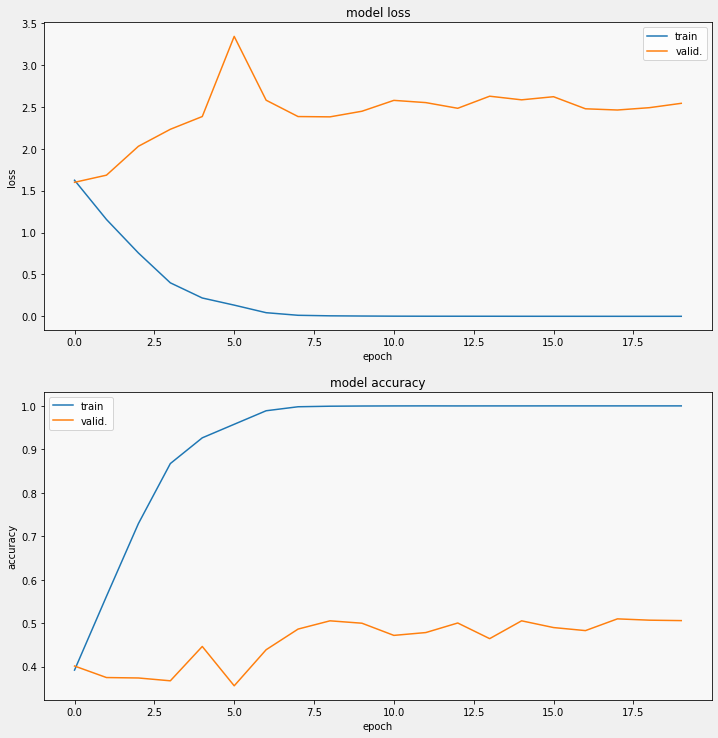

In [17]:
# We will display the loss and the accuracy of the model for each epoch
# NOTE: this is a little fancy display than is shown in the textbook
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# We store the performance during training in a variable named 'history'. The x-axis is the training time or number of epochs.
#    Accuracy: Accuracy of the predictions; hopefully this is increasing to near 1.0
#    Loss: How close the output is to the desired output; this should decrease to near 0.0
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

# Submission

Kaggle does not provide sample test images for running the notebook. These are only available once you submit your notebook for scoring. So, the code below checks if the test_images are available. If they are, we know we are doing an official submission, otherwise we fake it.

In [18]:
# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print ("Test images found")
    # do the same thing as the last cell but on the test\holdout set
    N = test_df.shape[0]
    x_test = np.empty((N, 224, 224, 3), dtype=np.float32)
    for i, image_id in enumerate(tqdm(test_df['image_id'])):
        x_test[i, :, :, :] = preprocess_image(
            f'../input/prostate-cancer-grade-assessment/test_images/{image_id}.tiff'
        )
        
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(BATCH_SIZE)
    )
else: 
    print ("===== Problem ==== No test images found")

    
sample_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_train)
    .batch(BATCH_SIZE)
)

===== Problem ==== No test images found


NameError: name 'x_train' is not defined

### Debug code
This is just some code I was using to debug the submission process. It should be removed enventually.

y_sample = model.predict(sample_test_dataset)

print (y_sample)
print (type(y_sample))
y_max = np.argmax(y_sample, axis=1)     # Select index with the highest probability for each test image
print (y_max)
print (train_df['isup_grade'][0:50])

In [19]:
import random

if os.path.exists('../input/prostate-cancer-grade-assessment/test_images'):
    print ("found test data")
    y_test = model.predict(test_dataset)
    results = np.argmax(y_test, axis=1)     # Select index with the highest probability for each test image
    test_df['isup_grade'] = results
    test_df['isup_grade'] = test_df['isup_grade'].astype(int)
    test_df.to_csv('submission.csv', index=False)
else: # if test is not available, just submit some random values
    print ("No test data found, using some random values")  
    random.seed(42)
    submission = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
    results = np.random.randint(0,6,len(submission))
    submission['isup_grade'] = results
    submission.to_csv('submission.csv', index=False)

No test data found, using some random values


# Mini Project: Improve this notebook

## Mini-Project Writeup 1: Prostrate Cancer Challenge Summary
Read about the [Prostate cANcer graDe Assessment (PANDA) Challenge](https://www.kaggle.com/c/prostate-cancer-grade-assessment) in Kaggle.

Write a short summary of the challenge:

- What is the goal of the challenge?
- What types of images are provided?
- What should the model predict? What is an ISUP grade?

*Make sure you put this in your own words--do not just cut/paste from Kaggle*

## Mini-Project Writeup 2: Image Augmentation

In the code above, the `data_augment(image, label)` method can be used to modify the images during training. This uses the tensorflow methods such as 
> image = tf.image.random_flip_up_down(image)

See the tf.image for documentation -- https://www.tensorflow.org/api_docs/python/tf/image



Implement some sort of image augmentation in your model by adjusting the `data_augment(image, label)` method. Train the network with this method and describe your results.

*Feel free to post your results to the course discussion area.*

Then review the first portion of Iafoss's notebook,[PANDA concat tile pooling starter](https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-0-79-lb) and describe the image augmenation he suggests. 

# Mini-Project Writeup 3: Modify the Model 

Try at least one other adjustment to this notebook. This could include changing the network structure, learning epochs, optimizer, etc.

Write a paragraph summarizing your results and analyze why you think they turned out the way they did.